Epoch [0/1], Loss: 9.2442
Epoch [0/1], Loss: 4.6710
Epoch [0/1], Loss: 1.9618
Epoch [0/1], Loss: 1.0379
Epoch [0/1], Loss: 1.4407
Epoch [0/1], Loss: 2.2828
Epoch [0/1], Loss: 2.8186
Epoch [0/1], Loss: 2.9522
Epoch [0/1], Loss: 2.5367
Epoch [0/1], Loss: 2.0342
Epoch [0/1], Loss: 1.4363
Epoch [0/1], Loss: 1.0866
Epoch [0/1], Loss: 0.9567
Epoch [0/1], Loss: 1.0627
Epoch [0/1], Loss: 1.2645
Epoch [0/1], Loss: 1.3756


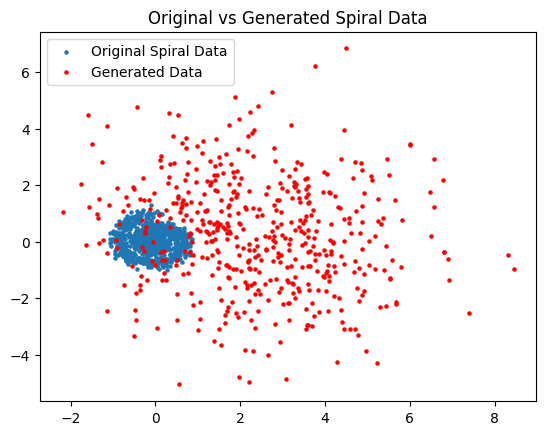

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# 1. Generate the Spiral Dataset
def generate_spiral_data(n_points=1000, noise_std=0.1):
    theta = np.linspace(0, 4 * np.pi, n_points) 
    r = np.linspace(0, 1, n_points) 
    x = r * np.sin(theta) + noise_std * np.random.randn(n_points) 
    y = r * np.cos(theta) + noise_std * np.random.randn(n_points)  
    return np.stack((x, y), axis=-1)

# 2.  Diffusion Model
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(3, 64)  # Input now takes x, y, and t
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x, t):
       
        t = t.float().unsqueeze(1)  # Shape manipulation for concatenation
        x = torch.cat([x, t], dim=1)  # Concatenate time information
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 3. Prepare Data and Model
spiral_data = generate_spiral_data()
spiral_data_tensor = torch.tensor(spiral_data, dtype=torch.float32)
dataset = TensorDataset(spiral_data_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 4. Training the Diffusion Model (Denoising)
epochs = 1
timesteps = 100  # Number of diffusion steps

# Noise schedule (linear)
def linear_schedule(timesteps):
    beta_start = 1e-4
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

betas = linear_schedule(timesteps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

model = DiffusionModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    for batch in dataloader:
        data = batch[0]

        optimizer.zero_grad()
        loss = 0.0
        batch_size = data.shape[0]

        
        for t in range(timesteps):
            noise = torch.randn_like(data)
            sqrt_alpha_cumprod_t = torch.sqrt(alphas_cumprod[t])
            sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alphas_cumprod[t])

            # Add noise
            noisy_data = sqrt_alpha_cumprod_t * data + sqrt_one_minus_alpha_cumprod_t * noise

            # Predict the noise
            t_tensor = torch.tensor([t] * batch_size)  # Pass timestep t
            predicted_noise = model(noisy_data, t_tensor)

            
            loss += nn.MSELoss()(predicted_noise, noise)

        loss = loss / timesteps  # Average loss over timesteps
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")


def generate_new_data(model, timesteps, alphas, alphas_cumprod, n_samples=500):
    model.eval()
    with torch.no_grad():
        x_t = torch.randn(n_samples, 2)

        for t in reversed(range(timesteps)):
            t_tensor = torch.tensor([t] * n_samples)
            predicted_noise = model(x_t, t_tensor)

            beta_t = betas[t]
            if t > 0:
                alpha_t_minus_one = alphas_cumprod[t-1]
                alpha_t = alphas_cumprod[t]
                sigma_t = torch.sqrt(beta_t*(1-alpha_t_minus_one)/(1-alpha_t))
            else:
                sigma_t = torch.sqrt(betas[0])

            noise = torch.randn_like(x_t)
            mean = (1 / torch.sqrt(alphas[t])) * (x_t - (betas[t] / torch.sqrt(1 - alphas_cumprod[t])) * predicted_noise)
            x_t = mean + sigma_t * noise

    return x_t

# 6. Generate New Data
generated_data = generate_new_data(model, timesteps, alphas, alphas_cumprod, n_samples=500)

# 7. Visualize the Original and Generated Data
plt.scatter(spiral_data[:, 0], spiral_data[:, 1], s=5, label="Original Spiral Data")
plt.scatter(generated_data[:, 0].numpy(), generated_data[:, 1].numpy(), s=5, color='red', label="Generated Data")
plt.title("Original vs Generated Spiral Data")
plt.legend()
plt.show()